# Protein domain family enrichment analysis

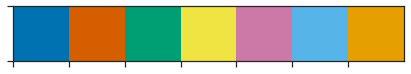

In [2]:
import sys
import os
from glob import glob
import random
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from joblib import Parallel, delayed

import pybedtools as pybt

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

## Nanopore protein family enrichment analysis

In [ ]:
def domain_count(interpro_domains):
    interpro_domains = interpro_domains.to_dataframe(names=COLS)[['interpro_id', 'locus_id']]
    interpro_domains['interpro_id'] = interpro_domains.interpro_id.str.split('|', expand=True)[2]
    interpro_domains = interpro_domains.drop_duplicates()
    return Counter(interpro_domains.interpro_id)


COLS = [
    'chrom', 'start', 'end', 'interpro_id', 'score', 'strand',
    'thickstart', 'thickend', 'color', 'nexons', 'block_sizes', 'block_starts',
    'chrom2', 'start2', 'end2', 'locus_id', 'score2', 'strand2',
    'wass_d', 'dir', 'pval', 'fdr', 'a', 'b'
]


def random_shuffle_intersect(sig, pro_dom, incl, chromsizes):
    r = pybt.BedTool(pro_dom).set_chromsizes(chromsizes).shuffle(incl=incl)
    e = domain_count(r.intersect(pybt.BedTool(sig), s=True, wa=True, wb=True))
    return e


def protein_family_enrichment_analysis(tested_loci_bed_fn, test_sig_filter,
                                       interpro_genomic_mapping_bed_fn,
                                       chromsizes, nperm=999, proc=12):
    tested = pybt.BedTool(tested_loci_bed_fn)
    pro_dom = pybt.BedTool(interpro_genomic_mapping_bed_fn)
    tested_pro_dom = pro_dom.intersect(
        tested, s=True, u=True
    )

    sig = tested.filter(test_sig_filter).saveas()
    obs = domain_count(tested_pro_dom.intersect(sig, s=True, wa=True, wb=True))

    exp = Parallel(proc)(
        delayed(random_shuffle_intersect)(
            sig.fn, tested_pro_dom.fn, tested_loci_bed_fn, chromsizes,
        ) for _ in range(nperm)
    )
    res = {}
    for f, c_obs in obs.items():
        c_exp = np.array([e[f] for e in exp])
        p_val = (sum(c_exp >= c_obs) + 1) / (nperm + 1)
        logfc = np.log2((c_obs + 0.5) / (np.median(c_exp) + 0.5))
        res[f] = (c_obs, np.median(c_exp), logfc, p_val)
    res = pd.DataFrame.from_dict(res, orient='index', columns=['obs', 'exp', 'logfc', 'pval'])
    _, res['fdr'], *_ = multipletests(res.pval, method='fdr_bh')
    return res

In [3]:
def get_chromsizes(chromsizes_fn):
    cs = {}
    with open(chromsizes_fn) as f:
        for record in f:
            chrom, ln, *_ = record.split()
            ln = int(ln)
            cs[chrom] = (0, ln)
    return cs

In [4]:
interpro_bed_fn = '../nanopore_apa_pipeline/annotations/araport_interpro_mapping.bed'
chrom_sizes = get_chromsizes(
    '../nanopore_apa_pipeline/annotations/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa.fai'
)

In [12]:
FPAox_res = protein_family_enrichment_analysis(
    '../nanopore_apa_pipeline/pipeline/apa_results/35SFPA_vs_col0.apa_results.bed',
    lambda r: (float(r[6]) > 25) & (float(r[9]) < 0.05),
    interpro_bed_fn, chrom_sizes, nperm=19999, proc=48,
)

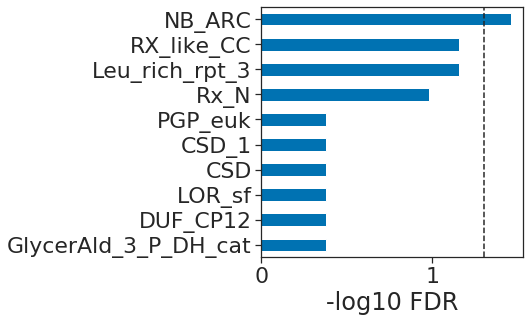

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
np.negative(np.log10(
    FPAox_res.sort_values(['fdr', 'logfc'], ascending=[False, True]).tail(n=10).fdr
)).plot.barh()
ax.axvline(-np.log10(0.05), ls='--', color='#252525')
ax.set_xlabel('-log10 FDR')
plt.tight_layout()
plt.savefig('figures/35S_FPA_nanopore_prot_domain_enrichment.svg')
plt.show()

In [18]:
fpa8_res = protein_family_enrichment_analysis(
    '../nanopore_apa_pipeline/pipeline/apa_results/fpa8_vs_col0.apa_results.bed',
    lambda r: (float(r[6]) > 25) & (float(r[9]) < 0.05),
    interpro_bed_fn, chrom_sizes, nperm=19999
)

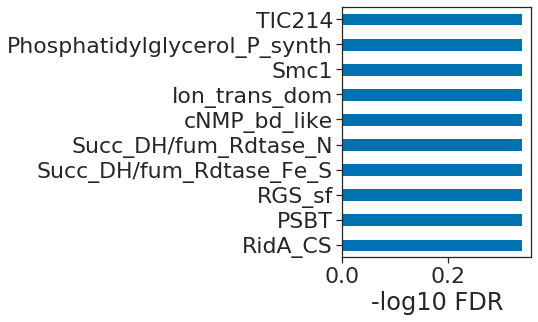

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
np.negative(np.log10(
    fpa8_res.sort_values('fdr', ascending=False).tail(n=10).fdr
)).plot.barh()
ax.set_xlabel('-log10 FDR')
plt.tight_layout()

In [22]:
FPAox_res_h = protein_family_enrichment_analysis(
    '../helicos_apa_pipeline/pipeline/apa_results/35SFPA_vs_col0.apa_results.bed',
    lambda r: (float(r[6]) > 25) & (float(r[9]) < 0.05),
    interpro_bed_fn, chrom_sizes, nperm=19999, proc=48
)

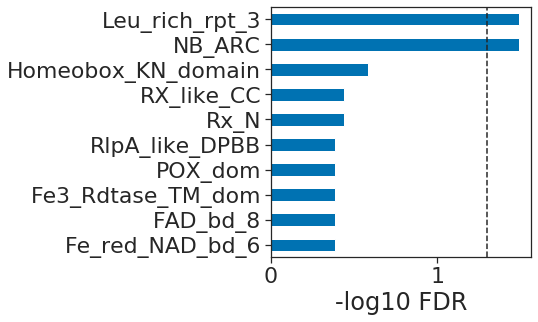

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
np.negative(np.log10(
    FPAox_res_h.sort_values(['fdr', 'logfc'], ascending=[False, True]).tail(n=10).fdr
)).plot.barh()
ax.axvline(-np.log10(0.05), ls='--', color='#252525')
ax.set_xlabel('-log10 FDR')
plt.tight_layout()
plt.savefig('figures/35S_FPA_helicos_prot_domain_enrichment.svg')
plt.show()

In [26]:
fpa8_res_h = protein_family_enrichment_analysis(
    '../helicos_apa_pipeline/pipeline/apa_results/fpa8_vs_col0.apa_results.bed',
    lambda r: (float(r[6]) > 25) & (float(r[9]) < 0.05),
    interpro_bed_fn, chrom_sizes, nperm=19999
)

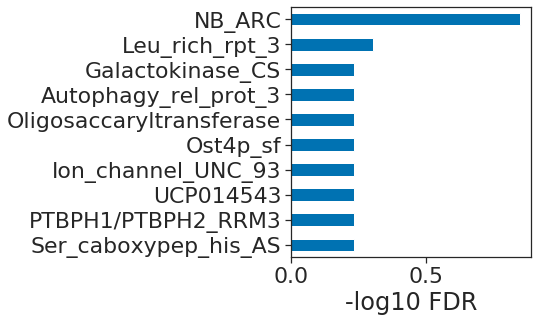

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
np.negative(np.log10(
    fpa8_res_h.sort_values(['fdr', 'logfc'], ascending=[False, True]).tail(n=10).fdr
)).plot.barh()
ax.set_xlabel('-log10 FDR')
plt.tight_layout()